In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import os.path
from sklearn.metrics import r2_score
import os
import matplotlib.pyplot as plt
from datetime import datetime
import time
import timm
from PIL import Image

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print('On GPU') if device == torch.device("cuda:0") else print('On CPU')

On GPU


In [3]:
class Hyperparameter:
    num_predictions: int    = 6

    # hyperparams
    batch_size: int         = 64
    num_epochs: int         = 8
    train_test_split: float = 0.9

    # bookkeeping
    batch_report_gap: int   = 189 # 10 # 81 # 189
    sav_model_epoch: bool   = True
    vals_per_epoch: int     = 3

    # optimizer
    learning_rate: float    = 0.0005
#     learning_rate: float    = 0.000001
#     lr_decay: float         = 0.9

hp = Hyperparameter()

# data processor

In [4]:
MEAN = [113.82422637939453/255, 114.86695861816406/255, 85.6895751953125/255]
STD = [46.77458190917969/255, 45.75661849975586/255, 45.359466552734375/255]

augment_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees=(-90, 90)),
    torchvision.transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0), antialias=True),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=MEAN, std=STD),
    
    ])

standard_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=MEAN, std=STD)
])


class DataProcessor():
    def __init__(self):
        super().__init__()
        
        self.train_data = pd.read_csv(
            '/kaggle/input/cs-480-2024-spring/data/train.csv')
        self.eval_data = pd.read_csv(
            '/kaggle/input/cs-480-2024-spring/data/test.csv')
#         self.train_data = pd.read_csv(os.path.join('data', 'train.csv'))
#         self.eval_data = pd.read_csv(os.path.join('data', 'test.csv'))

        self.x_outlier_cutoff = 5
        self.y_outlier_cutoff = 3

    def get_and_process_train_data(self):

        X = self.train_data[self.train_data.columns[1:164]]
        Y = self.train_data[self.train_data.columns[164:]]

        self.get_transform_params_X(X)
        X_NORMALISED = self.normalise_data(X)
        X_CLEANED, x_dropped_indices = self.clean_X(X_NORMALISED)

        self.get_transform_params_Y(Y)
        Y_LOG_NORMALISED = self.transform_Y(Y)
        Y_CLEANED, y_dropped_indices = self.clean_Y(Y_LOG_NORMALISED) 

        X_CLEANED.drop([i for i in y_dropped_indices if i not in x_dropped_indices], inplace=True) 
        X_CLEANED.reset_index(drop=True, inplace=True)
        Y_CLEANED.drop([i for i in x_dropped_indices if i not in y_dropped_indices], inplace=True) 
        Y_CLEANED.reset_index(drop=True, inplace=True)
        # 2299 rows dropped total

        X_IMG_IDS = self.train_data[self.train_data.columns[0:1]].drop(set(x_dropped_indices+y_dropped_indices))
        X_IMG_IDS.reset_index(drop=True, inplace=True)

        return X_IMG_IDS, X_CLEANED, Y_CLEANED

    def get_and_process_eval_data(self):
        X_EVAL = self.eval_data[self.eval_data.columns[1:]]
        X_EVAL_NORMALISED = self.normalise_data(X_EVAL)

        X_EVAL_IMG_IDS = self.eval_data[self.eval_data.columns[0:1]]

        return X_EVAL_IMG_IDS, X_EVAL_NORMALISED
    
    ########################################
    # X (FEATURE) DATA PROCESSING:
    ########################################

    def get_transform_params_X(self, X):
        self.X_means = X.mean()
        self.X_stds = X.std()

    def normalise_data(self, X):
        """ Convert 'data' into Z-score """
        return (X - self.X_means) / self.X_stds

    def clean_X(self, X):
        """ 
        Drop X values greater than self.x_outlier_cutoff=5 stdevs away from mean 
        Input is already in Z score.
        Return new df, list of indices dropped
        """
        rows_to_drop = X[(np.abs(X) > self.x_outlier_cutoff).any(axis=1)]
        indices_to_drop = rows_to_drop.index
        new_Y = X.drop(indices_to_drop)

        return new_Y, indices_to_drop.tolist()

    ########################################
    # Y (LABEL) DATA PROCESSING:
    ########################################

    def get_transform_params_Y(self, Y):
        self.Y_mins = np.min(Y, axis=0)
        self.Y_means = np.mean(np.log10(Y - self.Y_mins + 1e-6), axis=0)
        self.Y_stds = np.std(np.log10(Y - self.Y_mins + 1e-6), axis=0)

    def transform_Y(self, Y):
        """ Transform LABELS by their log and then Z score. """
        Y_zerod = Y - self.Y_mins
        log_Y = np.log10(Y_zerod + 1e-6)
        normalized_Y = (log_Y - self.Y_means) / self.Y_stds
        # standardized_Y = (normalized_Y + self.y_outlier_cutoff) / (2 * self.y_outlier_cutoff)
        standardized_Y = normalized_Y
        return standardized_Y

    def inv_transform_Y(self, Y):
        """ Restore labels """
        # normalized_Y = Y * (2 * self.y_outlier_cutoff) - self.y_outlier_cutoff
        normalized_Y = Y
        original_Y = 10 ** (normalized_Y * self.Y_stds + self.Y_means) + self.Y_mins
        return original_Y
    
    def clean_Y(self, Y):
        """ 
        Drop Y values that are more than 
        self.y_outlier_cutoff stdevs away from mean
        Input is already in Z score.
        Return new df, list of indices dropped
        """
        # indices_to_drop = Y.index[(Y > 1).any(axis=1)].append(Y.index[(Y < 0).any(axis=1)])
        indices_to_drop = Y.index[(np.abs(Y) > self.y_outlier_cutoff).any(axis=1)]
        new_Y = Y.drop(indices_to_drop)
        return new_Y, indices_to_drop.tolist()

    
    ########################################
    # DATA VISUALISATIONS
    ########################################

    def hist(self, data, bins=50):
        plt.figure(figsize=(10,2))
        plt.hist(data, bins=bins)
        plt.show()


    
class CustomDataset(Dataset):
    def __init__(self, img_id, data, target, img_dir, transform, noise=False):
        self.img_id = img_id
        self.data_frame = data
        self.target = target
        self.img_dir = img_dir
        self.transform = transform
        
        self.noise = noise # add gaussian noise to ancillary data

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.img_id['id'][idx]}.jpeg")
#         image = np.array(plt.imread(img_name), dtype=np.float32)
        image = Image.open(img_name)
        image = self.transform(image)
        
        training_data = self.data_frame[idx]
        if self.noise:
            noise = np.random.normal(0, 0.005, training_data.shape).astype(np.float32)
            training_data = training_data + noise
        training_data = torch.tensor(training_data)

        target_data = torch.tensor(self.target[idx])

        return image, training_data, target_data

# bookkeeper

In [5]:
class BookKeeper():
    def __init__(self, batches_per_epoch, batch_report_gap=hp.batch_report_gap): 
        
        # params
        self.batches_per_epoch = batches_per_epoch 
        self.batch_report_gap = batch_report_gap

        # graphs
        self.lists = {
            'batch_loss': {'batch': [], 'value': []},
            'train_loss': {'batch': [], 'value': []},
            'test_loss': {'batch': [], 'value': []},
            'test_r2': {'batch': [], 'value': []}, 
            'actual_r2': {'batch': [], 'value': []}, 
        }

        # timer
        self.batches_completed = 0
        self.epochs_completed = 0


    ######################################## 
    # GRAPHS
    ########################################

    def append(self, key, val):
        self.lists[key]['batch'].append(self.batches_completed)
        self.lists[key]['value'].append(val)

    def show_loss(self):
        plt.figure(figsize=(10,3))
        plt.title('losses')
#         plt.xticks(np.arange(0, np.array(self.lists['train_loss']['batch']).max()+self.batches_per_epoch, 
#                              self.batches_per_epoch))
        plt.plot(
                 self.lists['train_loss']['value'],
                 label='train loss')
        plt.plot(
                 self.lists['test_loss']['value'],
                 label='test loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def show_plots(self):
        self.show_loss()

#         for k in ['batch_loss', 'test_r2', 'actual_r2']:
        plt.figure(figsize=(10,3))
        plt.title('r2')
#         plt.xticks(np.arange(0, np.array(self.lists['test_r2']['batch']).max()+self.batches_per_epoch, 
#                              self.batches_per_epoch))
        # plt.ylim(0, np.mean(data) + 3 * np.std(data))
        plt.plot(self.lists['test_r2']['value'], label='transformed r2')
        plt.plot(self.lists['actual_r2']['value'], label='actual r2')
        plt.legend()
        plt.grid(True)
        plt.show()

    ######################################## 
    # CLOCK 
    ########################################


    def tick_batch(self, batch_loss):
        self.batches_completed += 1
        self.append('batch_loss', batch_loss)

        if self.batches_completed % self.batch_report_gap == 0:
            self.report_batch(batch_loss = np.mean(self.lists['batch_loss']['value'][:-10]))

    def report_batch(self, batch_loss):
        epochs_completed = self.batches_completed // self.batches_per_epoch
        batches_completed = self.batches_completed % self.batches_per_epoch
        print('Epoch', f"{epochs_completed : .2f}",
              'Batch', f"{batches_completed : 04}",
              batch_loss, 
              datetime.fromtimestamp(time.time()).strftime("%H:%M:%S"))

    def tick_epoch(self, train_loss, test_loss, transformed_r2, actual_r2):
        # epochs_completed = self.batches_completed // self.batches_per_epoch
        self.epochs_completed += 1

        self.append('train_loss', train_loss)
        self.append('test_loss', test_loss)
        self.append('test_r2', transformed_r2)
        self.append('actual_r2', actual_r2)
        
        print('### Epoch', f"{self.epochs_completed : .2f}", '|',
              'train_loss', train_loss, 
              'test_loss', test_loss, 
              'test_r2', transformed_r2, 
              'actual_r2', actual_r2)
        print()


# data loading

In [6]:
dp = DataProcessor()

X_IMG_IDS, X_CLEANED, Y_CLEANED = dp.get_and_process_train_data()
X_EVAL_IMG_IDS, X_EVAL_NORMALISED = dp.get_and_process_eval_data()

TRAIN_IMG_DIR = os.path.join('/kaggle/input/cs-480-2024-spring/data/train_images')
EVAL_IMG_DIR = os.path.join('/kaggle/input/cs-480-2024-spring/data/test_images')

X = np.array(X_CLEANED, dtype=np.float32)#[:1000]
Y = np.array(Y_CLEANED, dtype=np.float32)#[:1000]
TRAIN_TEST_SPLIT = int(np.round(hp.train_test_split * len(X)))

TRAIN_IMG_ID = X_IMG_IDS[:TRAIN_TEST_SPLIT]
TRAIN_X = X[:TRAIN_TEST_SPLIT]
TRAIN_Y = Y[:TRAIN_TEST_SPLIT]
TRAIN_DATASET = CustomDataset(TRAIN_IMG_ID, TRAIN_X, TRAIN_Y, img_dir=TRAIN_IMG_DIR, transform=augment_transform, noise=True)
TRAIN_DATALOADER = DataLoader(TRAIN_DATASET, batch_size=hp.batch_size, shuffle=True)

TEST_IMG_ID = X_IMG_IDS[TRAIN_TEST_SPLIT:].reset_index(drop=True)
TEST_X = X[TRAIN_TEST_SPLIT:]
TEST_Y = Y[TRAIN_TEST_SPLIT:]
TEST_DATASET = CustomDataset(TEST_IMG_ID, TEST_X, TEST_Y, img_dir=TRAIN_IMG_DIR, transform=standard_transform)
TEST_DATALOADER = DataLoader(TEST_DATASET, batch_size=hp.batch_size, shuffle=False)

EVAL_X = np.array(X_EVAL_NORMALISED, dtype=np.float32)
EVAL_Y = np.zeros((6391,6), dtype=np.float32) # empty
EVAL_DATASET = CustomDataset(X_EVAL_IMG_IDS, EVAL_X, EVAL_Y, img_dir=EVAL_IMG_DIR, transform=standard_transform)
EVAL_DATALOADER = DataLoader(EVAL_DATASET, batch_size=hp.batch_size, shuffle=False)

print(TRAIN_X.shape, TRAIN_Y.shape, len(TRAIN_DATALOADER))
print(TEST_X.shape, TEST_Y.shape, len(TEST_DATALOADER))
print(EVAL_X.shape, EVAL_Y.shape, len(EVAL_DATALOADER))


(36240, 163) (36240, 6) 567
(4027, 163) (4027, 6) 63
(6391, 163) (6391, 6) 100


# model def'ns

In [7]:
img_output_size = 1000
fc_output_size = 256
num_predictions = 6


class BigBoyV2(nn.Module):
    def __init__(self):
        super(BigBoyV2, self).__init__()

        self.image_processor = timm.create_model('mobilenetv2_140', pretrained=True) # this one actually works...
#         self.image_processor = timm.create_model('mobilenetv3_large_100', pretrained=True)
#         self.image_processor = timm.create_model('mobilenetv4_conv_medium', pretrained=True)
        
        self.fc = FC()

        concat_size = img_output_size + fc_output_size
        self.linear_head = nn.Sequential(
            nn.Linear(concat_size, concat_size), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(concat_size, concat_size), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(concat_size, num_predictions),
        )
    
    def forward(self, img, data):
        img_result = self.image_processor(img)
        data_result = self.fc(data)
        combined = torch.cat((img_result, data_result), dim=1)

        return self.linear_head(combined)
    
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(163, 512), nn.ReLU(inplace=True), nn.Dropout(0.2),

#             nn.Linear(512, 512), nn.ReLU(inplace=True), nn.Dropout(0.2),
            
            nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.2),

            nn.Linear(256, fc_output_size)
        )

    def forward(self, input):
        return self.linear(input)



# model training f'ns

In [8]:
TRAIN_COLUMN_ORDER = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

In [9]:
# model_to_load = None
# model_to_load = os.path.join('model_savs', 'smallboyv3.sav')
model = BigBoyV2()
# if model_to_load:
#     model.load_state_dict(torch.load(model_to_load))
model.eval()
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=hp.learning_rate, weight_decay=0.02)
# lambda_lr = lambda step: hp.lr_decay ** step
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.70, patience=1,verbose=True)

criterion = nn.MSELoss()

bk = BookKeeper(batches_per_epoch=len(TRAIN_DATALOADER))
df = []

model.safetensors:   0%|          | 0.00/24.7M [00:00<?, ?B/s]

# running the model

In [10]:
def validate(test_dataloader):
    model.eval()

    test_loss = []
    acc_predictions = [] # hold onto predictions and targets for R2
    acc_targets = []

    with torch.no_grad():
        for images, data, target in test_dataloader:

            images = images.to(device)
            data = data.to(device)
            target = target.to(device)

            prediction = model(images, data)
            loss = criterion(prediction, target).item()
            test_loss.append(loss)

            acc_predictions.append(prediction)
            acc_targets.append(target)

    test_loss = np.mean(test_loss) # / len(test_dataloader)

    # calculate R2 of transformed Y
    acc_targets_cpu = [tensor.cpu().numpy() for tensor in acc_targets]
    acc_predictions_cpu = [tensor.cpu().numpy() for tensor in acc_predictions]
    targets = np.concatenate(acc_targets_cpu)
    predictions = np.concatenate(acc_predictions_cpu)
    transformed_r2 = r2_score(targets, predictions)

    try: # calculate R2 after inverse Y transform
        target_df = pd.DataFrame(targets, columns=TRAIN_COLUMN_ORDER)
        pred_df = pd.DataFrame(predictions, columns=TRAIN_COLUMN_ORDER)
        actual_target_df = dp.inv_transform_Y(target_df)
        actual_pred_df = dp.inv_transform_Y(pred_df)
        actual_r2 = r2_score(actual_target_df, actual_pred_df)
    except:
        actual_r2 = -1000

    return test_loss, transformed_r2, actual_r2

def train_one_epoch(train_dataloader, test_dataloader):
    model.train()

    running_loss = []

    for batch_idx, (images, data, target) in enumerate(train_dataloader):
        
        optimizer.zero_grad()

        images = images.to(device)
        data = data.to(device)
        target = target.to(device)

        prediction = model(images, data)
        loss = criterion(prediction, target)

        loss.backward()
        optimizer.step()

        bk.tick_batch(loss.item())
        running_loss.append(loss.item())

#         if batch_idx > len(train_dataloader)//10:
#             break # just train on a third of shuffled data every epoch

    

    test_loss, transformed_r2, actual_r2 = validate(test_dataloader)
    train_loss = np.array(running_loss).mean()
    bk.tick_epoch(train_loss, test_loss, transformed_r2, actual_r2)
    
    scheduler.step(test_loss)

    bk.show_plots() # plot every epoch


    return train_loss, test_loss, transformed_r2, actual_r2

def predict(dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, data, _ in dataloader:
            images = images.to(device)
            data = data.to(device)
            
            prediction = model(images, data).detach().cpu().numpy()
            predictions.append(prediction) # X4,X11,X18,X26,X50,X3112

    all_predictions_np = np.concatenate(predictions, axis=0)
    df = pd.DataFrame(all_predictions_np, columns=TRAIN_COLUMN_ORDER)
    # df = df[['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']] # format to id,X4,X11,X18,X50,X26,X3112

    # final_df = pd.concat([img_id, df], axis=1)
    return df

def predict_with_imgid(img_id, dataloader):
    df = dp.inv_transform_Y(predict(dataloader))
    return pd.concat([img_id, df], axis=1)

starting
Epoch  35.00 Batch  189 0.5444259521273485 08:03:42
Epoch  35.00 Batch  378 0.5433923399372315 08:04:51
Epoch  36.00 Batch  000 0.5423938263083145 08:06:02
### Epoch  36.00 | train_loss 0.4348761059304394 test_loss 0.5805448057159545 test_r2 0.3422938104294715 actual_r2 0.23601609882940133

Epoch 00036: reducing learning rate of group 0 to 2.0177e-05.


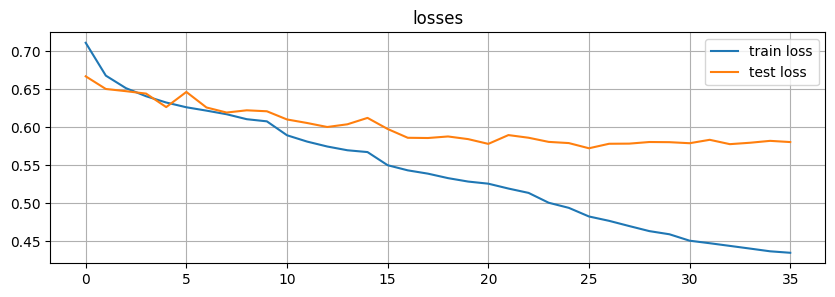

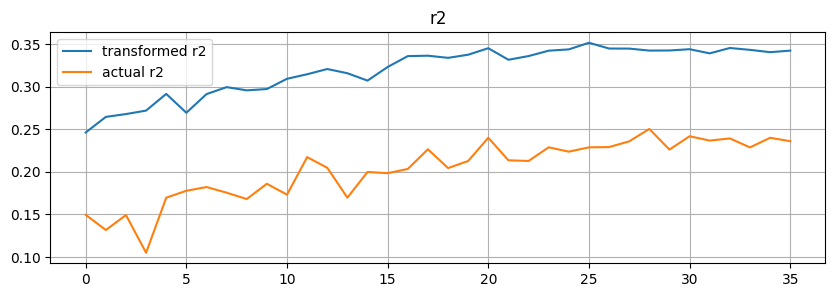

             id   X4_mean    X11_mean      X18_mean     X26_mean   X50_mean  \
0     154220505  1.071533  145.650583  19705.061789  3480.731735  15.002039   
1     195736552  1.056651  148.001345  19701.249719  3466.442730  14.964862   
2     182701773  0.928185  149.841510  19699.296335  3460.140088  14.901109   
3      27688500  1.032947  141.202470  19699.499853  3462.138758  15.801824   
4     195825045  0.929488  151.422309  19699.459831  3461.414456  14.898641   
...         ...       ...         ...           ...          ...        ...   
6386  195615880  0.953345  149.941841  19699.625239  3460.099151  14.687906   
6387  126224052  0.997929  143.669774  19699.547465  3461.345263  15.412957   
6388  178518157  1.171103  141.731053  19703.408503  3471.685542  15.361258   
6389  158746703  1.151912  144.234332  19705.103674  3501.382585  15.242947   
6390  104965612  0.956948  149.609393  19699.307201  3460.313769  14.913937   

         X3112_mean  
0     400095.799831  
1     3

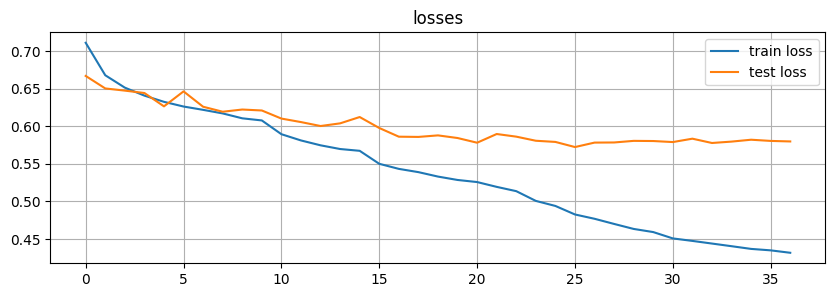

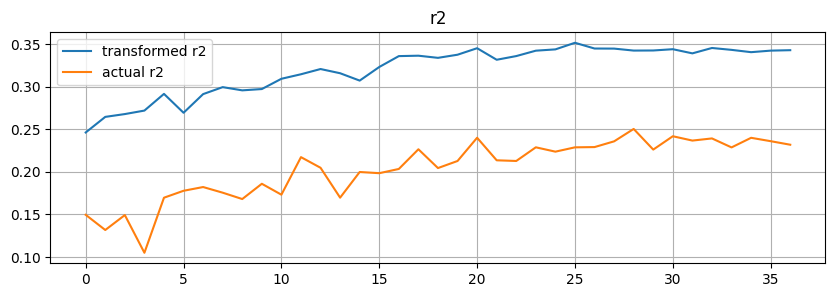

             id   X4_mean    X11_mean      X18_mean     X26_mean   X50_mean  \
0     154220505  1.073248  145.538817  19705.288919  3482.418189  15.019280   
1     195736552  1.059406  147.757237  19701.156328  3466.232630  14.977844   
2     182701773  0.917738  149.303078  19699.268026  3460.073527  14.924428   
3      27688500  1.030046  141.343488  19699.494009  3462.131765  15.792652   
4     195825045  0.922543  151.177043  19699.461699  3461.556234  14.918609   
...         ...       ...         ...           ...          ...        ...   
6386  195615880  0.954506  149.059997  19699.602006  3460.041017  14.736316   
6387  126224052  0.994414  143.200530  19699.532580  3461.360912  15.447534   
6388  178518157  1.176492  141.405793  19703.302703  3470.815302  15.416406   
6389  158746703  1.144659  144.441020  19704.657082  3497.029156  15.241116   
6390  104965612  0.956638  149.385733  19699.295334  3460.253966  14.929597   

         X3112_mean  
0     400147.556484  
1     3

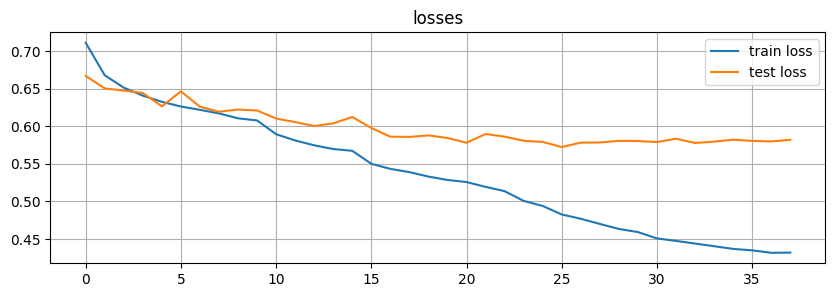

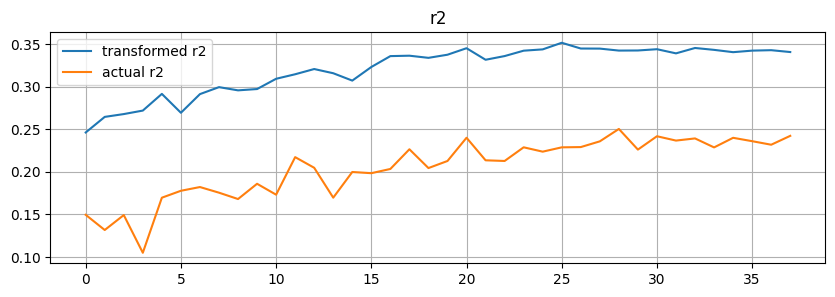

             id   X4_mean    X11_mean      X18_mean     X26_mean   X50_mean  \
0     154220505  1.072276  145.672188  19705.927463  3486.173416  15.019918   
1     195736552  1.071494  147.445190  19701.685989  3469.142033  15.016783   
2     182701773  0.917146  149.476901  19699.278940  3460.090553  14.915902   
3      27688500  1.032857  141.202058  19699.483217  3461.947501  15.829265   
4     195825045  0.917363  151.156363  19699.452193  3461.755110  14.929099   
...         ...       ...         ...           ...          ...        ...   
6386  195615880  0.947566  149.524532  19699.633166  3460.066168  14.695006   
6387  126224052  0.998998  143.459926  19699.547215  3461.479415  15.477455   
6388  178518157  1.168290  141.711821  19703.570009  3473.123894  15.380012   
6389  158746703  1.144459  144.533103  19704.853546  3500.743595  15.240658   
6390  104965612  0.959260  149.934013  19699.301395  3460.257105  14.887702   

         X3112_mean  
0     400349.156477  
1     3

In [25]:
epochs = 3
print('starting')
for e in range(epochs):
    _,_,_,r2 = train_one_epoch(TRAIN_DATALOADER, TEST_DATALOADER)
    pred = predict_with_imgid(X_EVAL_IMG_IDS, EVAL_DATALOADER)
    df.append((r2,pred))
    print(pred)

#     if r2 > 0.15:
#         filename = 'bigboyv3_' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '.sav'
#         torch.save(model.state_dict(), os.path.join('model_savs', filename))

In [26]:
lst = [i[0] for i in df]
indices = np.argsort(lst)[-3:][::-1]
for i in indices:
    print(i,lst[i])
    df[i][1].to_csv(f"hopefullybetter2_{i}.csv", index=False)

28 0.25037772040138917
37 0.24228366773035667
30 0.24181052894748892


In [13]:
# df[32][1].to_csv('hopefullybetter.csv', index=False)

In [14]:
# from IPython.display import Javascript
# Javascript("Ipython.notebook.session.delete()")
# !pkill jupyter